# AI Medical Diagnosis Model Comparison Showcase

This notebook demonstrates the inner workings of the Model Comparison page (`frontend/app/comparison/page.tsx`). It showcases how the BioClinical ModernBERT and RoBERTa Tagalog models process medical symptoms and generate diagnosis predictions.

## What This Notebook Covers
1. Setting up the backend connection
2. Defining model types and configurations
3. Creating diagnosis prediction functions
4. Testing single and multiple model predictions
5. Visualizing confidence and uncertainty metrics
6. Comparing model performance and predictions
7. Analyzing prediction differences between models

## 1. Import Required Libraries

In [2]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import TypedDict, Literal, Optional
import asyncio
from dataclasses import dataclass
from datetime import datetime

# Configure visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ All libraries imported successfully")
print(f"  - requests: API calls")
print(f"  - pandas: Data manipulation")
print(f"  - matplotlib & seaborn: Visualizations")
print(f"  - json: Response parsing")

✓ All libraries imported successfully
  - requests: API calls
  - pandas: Data manipulation
  - matplotlib & seaborn: Visualizations
  - json: Response parsing


## 2. Configure Backend Connection

In [3]:
# Backend configuration (matches the React component)
BACKEND_URL = "http://127.0.0.1:10000"  # Default Flask server URL
DIAGNOSIS_ENDPOINT = f"{BACKEND_URL}/diagnosis/new"

print(f"Backend Configuration:")
print(f"  URL: {BACKEND_URL}")
print(f"  Diagnosis Endpoint: {DIAGNOSIS_ENDPOINT}")
print()

# Test connectivity
def check_backend_connection():
    """Verify that the backend API is accessible"""
    try:
        response = requests.get(BACKEND_URL, timeout=2)
        return True
    except requests.exceptions.ConnectionError:
        return False
    except Exception as e:
        return False

is_connected = check_backend_connection()
status = "✓ Connected" if is_connected else "✗ Not Connected"
print(f"Backend Status: {status}")
if not is_connected:
    print(f"⚠️  Make sure the Flask backend is running at {BACKEND_URL}")
    print(f"   You can start it with: python backend/app.py")

Backend Configuration:
  URL: http://127.0.0.1:10000
  Diagnosis Endpoint: http://127.0.0.1:10000/diagnosis/new

Backend Status: ✗ Not Connected
⚠️  Make sure the Flask backend is running at http://127.0.0.1:10000
   You can start it with: python backend/app.py


## 3. Define Model Types and Labels

In [ ]:
# TypeScript types converted to Python TypedDict for reference
from typing import TypedDict, List

class DiagnosisResult(TypedDict, total=False):
    """Diagnosis result from the backend"""
    pred: str
    confidence: float
    uncertainty: float
    probs: List[str]
    model_used: str
    top_diseases: List[dict]  # List of {disease: str, probability: float}
    skip_followup: bool
    skip_reason: str

# Model identifiers and labels (matching React component)
ModelKey = Literal["BIOCLINICAL_MODERNBERT", "ROBERTA_TAGALOG"]

MODEL_LABEL = {
    "BIOCLINICAL_MODERNBERT": "BioClinical ModernBERT (English)",
    "ROBERTA_TAGALOG": "RoBERTa Tagalog",
}

MODEL_EMOJI = {
    "BIOCLINICAL_MODERNBERT": "🧠",  # Brain emoji for English model
    "ROBERTA_TAGALOG": "🌏",         # Globe emoji for Tagalog model
}

# Example symptoms for testing
EXAMPLE_SYMPTOMS = {
    "english": (
        "I thought it was just the flu, but this body ache was different, it felt like I had been beaten. "
        "I've had a fever of 39°C for three days. "
        "My head and joints also hurt, and there felt like pressure behind my eyes."
    ),
    "tagalog": (
        "Akala ko po trangkaso lang, pero iba po itong sakit ng katawan, parang binugbog ako. "
        "Tatlong araw na po akong may lagnat na 39°C. "
        "Masakit din po ang ulo ko at ang mga kasukasuan, at parang may pressure sa likod ng mga mata ko."
    ),
}

print("📋 Model Configuration:")
print()
for model_key, label in MODEL_LABEL.items():
    emoji = MODEL_EMOJI[model_key]
    print(f"{emoji} {label}")
print()
print("📝 Example Symptoms Available:")
print(f"  - English (for BioClinical ModernBERT)")
print(f"  - Tagalog (for RoBERTa Tagalog)")


📋 Model Configuration:

🧠 BioClinical ModernBERT (English)
🌏 RoBERTa Tagalog

📝 Example Symptoms Available:
  - English (for BioClinical ModernBERT)
  - Tagalog (for RoBERTa Tagalog)


## 4. Create Diagnosis Request Function

In [5]:
def run_diagnosis(symptoms: str) -> tuple[dict, Optional[str]]:
    """
    Send symptoms to the backend and get diagnosis prediction.
    
    This mirrors the `runOne` function in the React component:
    - Makes a POST request to /diagnosis/new
    - Includes error handling
    - Extracts the diagnosis result from the response
    
    Args:
        symptoms: Medical symptom description
        
    Returns:
        Tuple of (result_dict, error_message)
        - result_dict contains the DiagnosisResult if successful
        - error_message is None on success, or string describing the error
    """
    try:
        # Prepare the request payload
        payload = {"symptoms": symptoms}
        
        # Send POST request to backend
        response = requests.post(
            DIAGNOSIS_ENDPOINT,
            json=payload,
            headers={"Content-Type": "application/json"},
            timeout=30
        )
        
        # Handle HTTP errors
        if not response.ok:
            try:
                body = response.json()
                error_msg = body.get("message") or body.get("error") or response.reason
            except:
                error_msg = response.reason
            return {}, f"HTTP {response.status_code}: {error_msg}"
        
        # Parse response
        data = response.json()
        
        if "data" not in data:
            return {}, "Unexpected response format: missing 'data' field"
        
        result = data["data"]
        return result, None
        
    except requests.exceptions.Timeout:
        return {}, "Request timed out (30 seconds)"
    except requests.exceptions.ConnectionError:
        return {}, f"Connection failed. Is the backend running at {BACKEND_URL}?"
    except Exception as e:
        return {}, f"Unexpected error: {str(e)}"

# Display the function signature
print("✓ run_diagnosis() function created")
print()
print("Function signature:")
print("  run_diagnosis(symptoms: str) -> tuple[dict, Optional[str]]")
print()
print("Returns:")
print("  - result: Dictionary with diagnosis data")
print("  - error: None on success, error message on failure")

✓ run_diagnosis() function created

Function signature:
  run_diagnosis(symptoms: str) -> tuple[dict, Optional[str]]

Returns:
  - result: Dictionary with diagnosis data
  - error: None on success, error message on failure


## 5. Test Single Model Prediction

In [13]:
print("=" * 60)
print("Testing Single Model Prediction")
print("=" * 60)
print()

# Use the example English symptoms
test_symptoms = EXAMPLE_SYMPTOMS["english"]
print(f"📝 Input Symptoms (English):")
print(f'"{test_symptoms}"')
print()

# Make the API call
print("🔄 Sending request to backend...")
result, error = run_diagnosis(test_symptoms)

if error:
    print(f"❌ Error: {error}")
else:
    print("✓ Successful Response!")
    print()
    print("Raw Response Data:")
    print(json.dumps(result, indent=2))
    print()
    
    # Extract and display key fields
    print("📊 Key Metrics:")
    print(f"  Primary Diagnosis: {result.get('pred', 'N/A')}")
    print(f"  Model Used: {result.get('model_used', 'N/A')}")
    print(f"  Confidence: {result.get('confidence', 0):.2%}")
    print(f"  Uncertainty: {result.get('uncertainty', 0):.2%}")
    print(f"  Skip Follow-up: {result.get('skip_followup', False)}")
    
    if result.get('skip_reason'):
        print(f"  Skip Reason: {result['skip_reason']}")
    
    # Display top diseases if available
    if result.get('top_diseases'):
        print()
        print("🏥 Top Disease Predictions:")
        for idx, disease in enumerate(result['top_diseases'], 1):
            print(f"  {idx}. {disease['disease']}: {disease['probability']:.2%}")

Testing Single Model Prediction

📝 Input Symptoms (English):
"I thought it was just the flu at first. It was just a fever and body aches. But on the third day, the rashes on my legs started appearing, and my muscle joints were very painful. I couldn't eat properly because I felt like vomiting."

🔄 Sending request to backend...
✓ Successful Response!

Raw Response Data:
{
  "cdss": {
    "differential": [
      {
        "code": null,
        "label": "Dengue",
        "prob": 0.7413975596427917
      },
      {
        "code": null,
        "label": "Typhoid",
        "prob": 0.06492942571640015
      },
      {
        "code": null,
        "label": "Pneumonia",
        "prob": 0.024170927703380585
      }
    ],
    "knowledge": [
      {
        "link": "https://www.who.int/health-topics/dengue-and-severe-dengue",
        "source": "WHO guidance",
        "topic": "Dengue warning signs"
      },
      {
        "link": "https://www.cdc.gov/pneumonia/index.html",
        "source": "G

## 6. Compare Multiple Models

In [14]:
print()
print("=" * 60)
print("Comparing Multiple Models (Concurrent Requests)")
print("=" * 60)
print()

# Prepare test inputs
en_symptoms = EXAMPLE_SYMPTOMS["english"]
tl_symptoms = EXAMPLE_SYMPTOMS["tagalog"]

print("📝 Input Symptoms:")
print(f"  English: {en_symptoms[:50]}...")
print(f"  Tagalog: {tl_symptoms[:50]}...")
print()

# Make concurrent requests using Promise.all pattern (simulated with requests)
print("🔄 Sending both requests to backend...")
import time
start_time = time.time()

modernbert_result, modernbert_error = run_diagnosis(en_symptoms)
roberta_result, roberta_error = run_diagnosis(tl_symptoms)

elapsed = time.time() - start_time

print(f"✓ Completed in {elapsed:.2f} seconds")
print()

# Create a comparison dataframe
comparison_data = {
    "Model": ["BioClinical ModernBERT", "RoBERTa Tagalog"],
    "Diagnosis": [
        modernbert_result.get("pred", "ERROR") if not modernbert_error else "ERROR",
        roberta_result.get("pred", "ERROR") if not roberta_error else "ERROR"
    ],
    "Confidence": [
        modernbert_result.get("confidence", 0) if not modernbert_error else 0,
        roberta_result.get("confidence", 0) if not roberta_error else 0
    ],
    "Uncertainty": [
        modernbert_result.get("uncertainty", 0) if not modernbert_error else 0,
        roberta_result.get("uncertainty", 0) if not roberta_error else 0
    ],
    "Skip Followup": [
        modernbert_result.get("skip_followup", False) if not modernbert_error else False,
        roberta_result.get("skip_followup", False) if not roberta_error else False
    ],
}

comparison_df = pd.DataFrame(comparison_data)

print("📊 Comparison Results:")
print()
print(comparison_df.to_string(index=False))
print()

# Check for errors
if modernbert_error:
    print(f"⚠️  BioClinical ModernBERT Error: {modernbert_error}")
if roberta_error:
    print(f"⚠️  RoBERTa Tagalog Error: {roberta_error}")

# Detailed breakdown
if not modernbert_error and not roberta_error:
    print()
    print("🔍 Detailed Breakdown:")
    print()
    print("BioClinical ModernBERT (English):")
    print(f"  Prediction: {modernbert_result.get('pred')}")
    print(f"  Confidence: {modernbert_result.get('confidence'):.2%}")
    print(f"  Uncertainty: {modernbert_result.get('uncertainty'):.2%}")
    
    print()
    print("RoBERTa Tagalog:")
    print(f"  Prediction: {roberta_result.get('pred')}")
    print(f"  Confidence: {roberta_result.get('confidence'):.2%}")
    print(f"  Uncertainty: {roberta_result.get('uncertainty'):.2%}")
    
    # Check prediction agreement
    same_prediction = modernbert_result.get('pred') == roberta_result.get('pred')
    print()
    print(f"✓ Predictions Match: {same_prediction}")
    if same_prediction:
        print(f"  Both models agree on: {modernbert_result.get('pred')}")
    else:
        print(f"  Models disagree:")
        print(f"    - BioClinical: {modernbert_result.get('pred')}")
        print(f"    - RoBERTa: {roberta_result.get('pred')}")


Comparing Multiple Models (Concurrent Requests)

📝 Input Symptoms:
  English: I thought it was just the flu at first. It was jus...
  Tagalog: Akala ko po trangkaso lang nung una. Kasi lagnat a...

🔄 Sending both requests to backend...
✓ Completed in 12.07 seconds

📊 Comparison Results:

                 Model Diagnosis  Confidence  Uncertainty  Skip Followup
BioClinical ModernBERT    Dengue    0.707324     0.021577          False
       RoBERTa Tagalog    Dengue    0.923503     0.001731          False


🔍 Detailed Breakdown:

BioClinical ModernBERT (English):
  Prediction: Dengue
  Confidence: 70.73%
  Uncertainty: 2.16%

RoBERTa Tagalog:
  Prediction: Dengue
  Confidence: 92.35%
  Uncertainty: 0.17%

✓ Predictions Match: True
  Both models agree on: Dengue


## 7. Visualize Confidence and Uncertainty

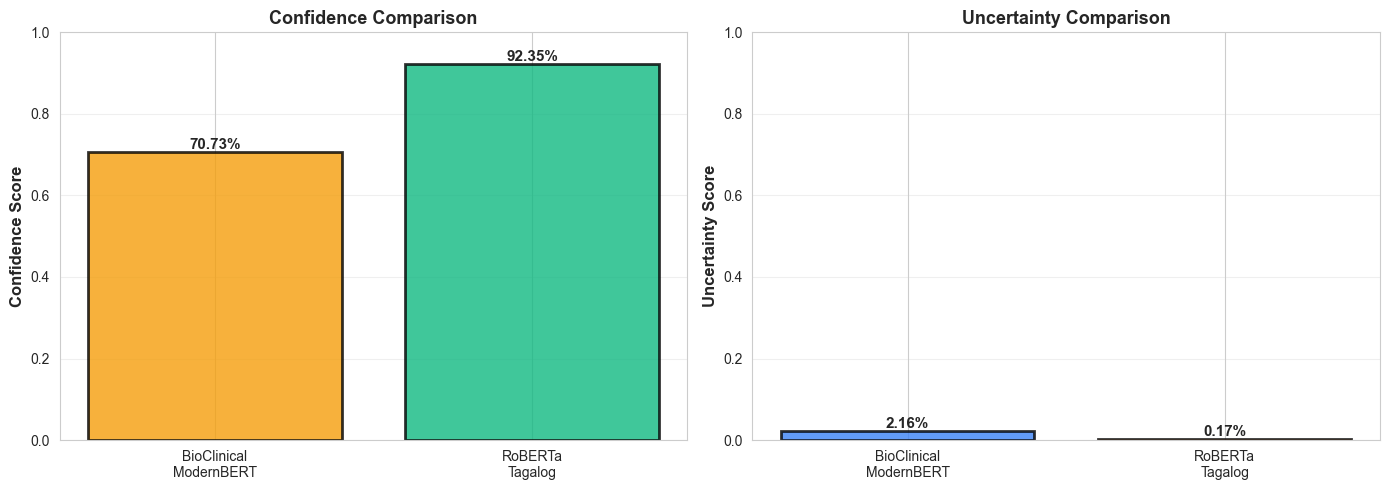

✓ Visualization generated successfully


In [15]:
if not modernbert_error and not roberta_error:
    # Create visualization for confidence and uncertainty
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    models = ["BioClinical\nModernBERT", "RoBERTa\nTagalog"]
    confidences = [
        modernbert_result.get("confidence", 0),
        roberta_result.get("confidence", 0)
    ]
    uncertainties = [
        modernbert_result.get("uncertainty", 0),
        roberta_result.get("uncertainty", 0)
    ]
    
    # Define confidence color mapping (matching React component)
    def get_confidence_color(conf):
        """Color based on confidence threshold"""
        if conf >= 0.9:
            return "#10b981"  # success (green)
        elif conf >= 0.7:
            return "#f59e0b"  # warning (amber)
        else:
            return "#ef4444"  # error (red)
    
    confidence_colors = [get_confidence_color(c) for c in confidences]
    
    # Subplot 1: Confidence comparison
    bars1 = axes[0].bar(models, confidences, color=confidence_colors, alpha=0.8, edgecolor="black", linewidth=2)
    axes[0].set_ylabel("Confidence Score", fontsize=12, fontweight="bold")
    axes[0].set_title("Confidence Comparison", fontsize=13, fontweight="bold")
    axes[0].set_ylim([0, 1])
    axes[0].grid(axis="y", alpha=0.3)
    
    # Add value labels on bars
    for bar, conf in zip(bars1, confidences):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{conf:.2%}',
                    ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    # Subplot 2: Uncertainty comparison
    bars2 = axes[1].bar(models, uncertainties, color=["#3b82f6", "#f97316"], alpha=0.8, edgecolor="black", linewidth=2)
    axes[1].set_ylabel("Uncertainty Score", fontsize=12, fontweight="bold")
    axes[1].set_title("Uncertainty Comparison", fontsize=13, fontweight="bold")
    axes[1].set_ylim([0, 1])
    axes[1].grid(axis="y", alpha=0.3)
    
    # Add value labels on bars
    for bar, unc in zip(bars2, uncertainties):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{unc:.2%}',
                    ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Visualization generated successfully")
else:
    print("⚠️  Cannot visualize - one or more models returned errors")

## 8. Display Top Disease Predictions


Top Disease Predictions

BioClinical ModernBERT:            RoBERTa Tagalog:
----------------------------------------------------------------------
1. Dengue: 70.73%                  1. Dengue: 92.35%
2. Typhoid: 7.24%                  2. Typhoid: 5.63%
3. Pneumonia: 2.60%                3. Impetigo: 1.25%
                                   4. Pneumonia: 0.77%


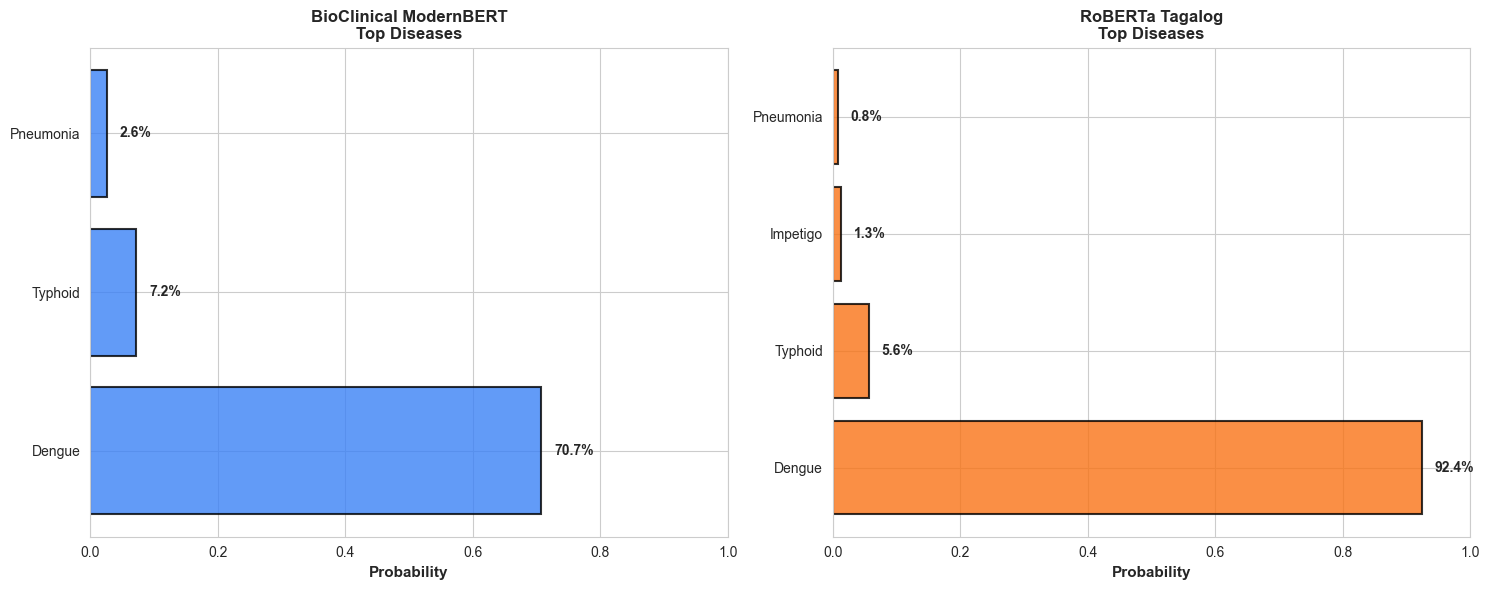

In [16]:
if not modernbert_error and not roberta_error:
    # Extract top diseases
    modernbert_diseases = modernbert_result.get("top_diseases", [])
    roberta_diseases = roberta_result.get("top_diseases", [])
    
    print()
    print("=" * 60)
    print("Top Disease Predictions")
    print("=" * 60)
    print()
    
    # Display side-by-side comparison
    print("BioClinical ModernBERT:".ljust(35) + "RoBERTa Tagalog:")
    print("-" * 70)
    
    max_diseases = max(len(modernbert_diseases), len(roberta_diseases))
    
    for i in range(max_diseases):
        modernbert_line = ""
        roberta_line = ""
        
        if i < len(modernbert_diseases):
            d = modernbert_diseases[i]
            modernbert_line = f"{i+1}. {d['disease']}: {d['probability']:.2%}"
        
        if i < len(roberta_diseases):
            d = roberta_diseases[i]
            roberta_line = f"{i+1}. {d['disease']}: {d['probability']:.2%}"
        
        print(modernbert_line.ljust(35) + roberta_line)
    
    # Visualize top diseases
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # BioClinical ModernBERT
    if modernbert_diseases:
        diseases_mb = [d["disease"] for d in modernbert_diseases]
        probs_mb = [d["probability"] for d in modernbert_diseases]
        
        axes[0].barh(diseases_mb, probs_mb, color="#3b82f6", alpha=0.8, edgecolor="black", linewidth=1.5)
        axes[0].set_xlabel("Probability", fontsize=11, fontweight="bold")
        axes[0].set_title("BioClinical ModernBERT\nTop Diseases", fontsize=12, fontweight="bold")
        axes[0].set_xlim([0, 1])
        
        # Add probability labels
        for i, (d, p) in enumerate(zip(diseases_mb, probs_mb)):
            axes[0].text(p + 0.02, i, f'{p:.1%}', va='center', fontweight='bold')
    
    # RoBERTa Tagalog
    if roberta_diseases:
        diseases_rt = [d["disease"] for d in roberta_diseases]
        probs_rt = [d["probability"] for d in roberta_diseases]
        
        axes[1].barh(diseases_rt, probs_rt, color="#f97316", alpha=0.8, edgecolor="black", linewidth=1.5)
        axes[1].set_xlabel("Probability", fontsize=11, fontweight="bold")
        axes[1].set_title("RoBERTa Tagalog\nTop Diseases", fontsize=12, fontweight="bold")
        axes[1].set_xlim([0, 1])
        
        # Add probability labels
        for i, (d, p) in enumerate(zip(diseases_rt, probs_rt)):
            axes[1].text(p + 0.02, i, f'{p:.1%}', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Cannot display top diseases - one or more models returned errors")

## 9. Analyze Model Performance Differences

In [17]:
if not modernbert_error and not roberta_error:
    print()
    print("=" * 60)
    print("Model Performance Analysis")
    print("=" * 60)
    print()
    
    # Key metrics comparison
    mb_conf = modernbert_result.get("confidence", 0)
    rt_conf = roberta_result.get("confidence", 0)
    mb_unc = modernbert_result.get("uncertainty", 0)
    rt_unc = roberta_result.get("uncertainty", 0)
    mb_pred = modernbert_result.get("pred", "Unknown")
    rt_pred = roberta_result.get("pred", "Unknown")
    
    print("📊 Key Metrics Comparison:")
    print()
    print(f"Confidence Difference: {abs(mb_conf - rt_conf):.2%}")
    print(f"  BioClinical: {mb_conf:.2%} | RoBERTa: {rt_conf:.2%}")
    print()
    
    print(f"Uncertainty Difference: {abs(mb_unc - rt_unc):.2%}")
    print(f"  BioClinical: {mb_unc:.2%} | RoBERTa: {rt_unc:.2%}")
    print()
    
    # Prediction agreement analysis
    same_pred = mb_pred == rt_pred
    print(f"Prediction Agreement:")
    print(f"  Same Diagnosis: {'✓ Yes' if same_pred else '✗ No'}")
    if not same_pred:
        print(f"    BioClinical: {mb_pred}")
        print(f"    RoBERTa: {rt_pred}")
    print()
    
    # Confidence categorization
    print("📈 Confidence Categorization (matching React UI):")
    print()
    
    def get_confidence_level(conf):
        if conf >= 0.9:
            return "🟢 High (≥90%)", "success"
        elif conf >= 0.7:
            return "🟡 Medium (≥70%)", "warning"
        else:
            return "🔴 Low (<70%)", "error"
    
    mb_level, mb_category = get_confidence_level(mb_conf)
    rt_level, rt_category = get_confidence_level(rt_conf)
    
    print(f"BioClinical ModernBERT: {mb_level}")
    print(f"RoBERTa Tagalog: {rt_level}")
    print()
    
    # Follow-up question logic
    print("❓ Follow-up Question Logic:")
    mb_skip = modernbert_result.get("skip_followup", False)
    rt_skip = roberta_result.get("skip_followup", False)
    
    print()
    print(f"BioClinical ModernBERT:")
    print(f"  Skip Follow-up: {'✓ Yes' if mb_skip else '✗ No'}")
    if mb_skip and modernbert_result.get("skip_reason"):
        print(f"  Reason: {modernbert_result['skip_reason']}")
    elif mb_skip:
        print(f"  Reason: High confidence threshold met")
    
    print()
    print(f"RoBERTa Tagalog:")
    print(f"  Skip Follow-up: {'✓ Yes' if rt_skip else '✗ No'}")
    if rt_skip and roberta_result.get("skip_reason"):
        print(f"  Reason: {roberta_result['skip_reason']}")
    elif rt_skip:
        print(f"  Reason: High confidence threshold met")
    
    print()
    print("=" * 60)
    print("Analysis Summary")
    print("=" * 60)
    print()
    
    # Summary statistics
    if same_pred:
        print(f"✓ Both models agree on diagnosis: {mb_pred}")
        avg_conf = (mb_conf + rt_conf) / 2
        print(f"  Average confidence: {avg_conf:.2%}")
    else:
        higher_conf_model = "BioClinical" if mb_conf > rt_conf else "RoBERTa"
        print(f"⚠️  Models disagree on diagnosis")
        print(f"  {higher_conf_model} model has higher confidence")
    
    print()
    
    if mb_skip and rt_skip:
        print("✓ Both models recommend skipping follow-up questions")
        print("  This indicates high confidence in the diagnosis")
    elif not mb_skip and not rt_skip:
        print("✓ Both models recommend follow-up questions")
        print("  This indicates uncertainty that warrants further investigation")
    else:
        print("⚠️  Models disagree on follow-up requirement")
        print("  Consider manual review for clinical decision-making")
else:
    print("⚠️  Cannot analyze - one or more models returned errors")


Model Performance Analysis

📊 Key Metrics Comparison:

Confidence Difference: 21.62%
  BioClinical: 70.73% | RoBERTa: 92.35%

Uncertainty Difference: 1.98%
  BioClinical: 2.16% | RoBERTa: 0.17%

Prediction Agreement:
  Same Diagnosis: ✓ Yes

📈 Confidence Categorization (matching React UI):

BioClinical ModernBERT: 🟡 Medium (≥70%)
RoBERTa Tagalog: 🟢 High (≥90%)

❓ Follow-up Question Logic:

BioClinical ModernBERT:
  Skip Follow-up: ✗ No

RoBERTa Tagalog:
  Skip Follow-up: ✗ No

Analysis Summary

✓ Both models agree on diagnosis: Dengue
  Average confidence: 81.54%

✓ Both models recommend follow-up questions
  This indicates uncertainty that warrants further investigation
